In [1]:
import glob
from netCDF4 import Dataset
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
#import cartopy
import warnings
warnings.filterwarnings("ignore")

In [2]:
### load CS2 data
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/radar_freeboard/'
awi_rf = np.array(Dataset(datapath+'CS2_AWI.nc')['Radar Freeboard'])
cpom_rf = np.array(Dataset(datapath+'CS2_CPOM.nc')['Radar Freeboard'])

In [3]:
### load OIB laser data

datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/OIB_EASE/'

days = np.arange(0,len(awi_rf))
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=int(days)) for days in days]

ql_laser = np.full(awi_rf.shape,np.nan) 
ql_snow = np.full(awi_rf.shape,np.nan) 

for day in days:
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if date in f:
            data = Dataset(datapath+f)
            Fl = np.array(data['Laser Freeboard'])
            ql_laser[day] = Fl
            snow = np.array(data['Snow Depth'])
            ql_snow[day] = snow

In [4]:
### load OIB snow data

datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/pySnowRadar_EASE/'

psr_snow = np.full(awi_rf.shape,np.nan) 

for day in days:
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if date in f:
            data = Dataset(datapath+f)
            snow = np.array(data['Snow Depth'])
            psr_snow[day] = snow

In [7]:
ql_snow[ql_snow>ql_laser] = np.nan
psr_snow[psr_snow>ql_laser] = np.nan

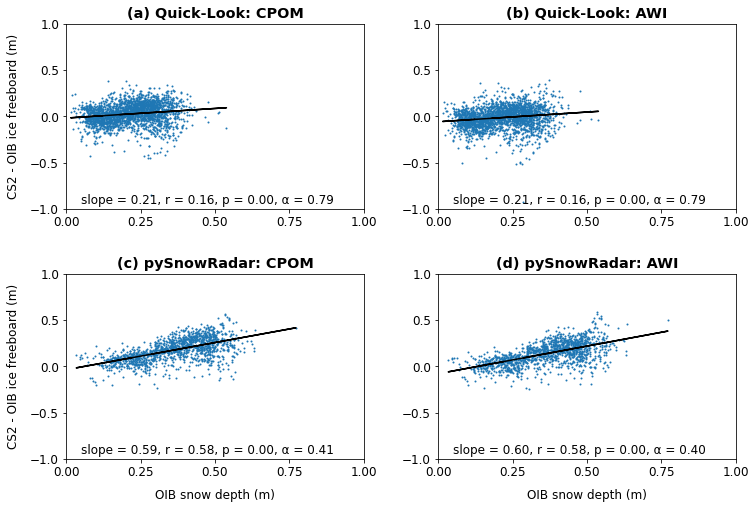

In [8]:
### plot 

names = ['Quick-Look: CPOM','Quick-Look: AWI','pySnowRadar: CPOM','pySnowRadar: AWI']
freebs = [cpom_rf,awi_rf,cpom_rf,awi_rf]
snows = [ql_snow,ql_snow,psr_snow,psr_snow]
nums = ['(a) ','(b) ','(c) ','(d) ']

fig = plt.figure(figsize=(12,8))
spec = gridspec.GridSpec(ncols=2, nrows=2, wspace=0.25, hspace=0.35)
plt.rc('font', size=12)

for count, name in enumerate(names):
        
    c = 3
    cs = 2.4
    hs = snows[count]
    Fl = ql_laser
    
    ### calculate OIB ice freeboard 
    Fi = Fl - hs
    Fi_cs2 = freebs[count] + (((c/cs) -1)*hs) 

    mask = np.where((~np.isnan(hs)) & (~np.isnan(Fi_cs2)) & (~np.isnan(Fi)))
    ax = plt.subplot(spec[count])
    ax.scatter(hs[mask],Fi_cs2[mask]-Fi[mask],s=1)
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_xlim([0,1])
    ax.set_xticks([0,0.25,0.5,0.75,1])
    
    a = scipy.stats.linregress(hs[mask],Fi_cs2[mask]-Fi[mask])
    line = a[0] * hs[mask] + a[1]
    ax.plot(hs[mask], line,color='k')
    ax.set_title(nums[count]+name,fontweight='bold')
    ax.text(0.05, 0.03, f"slope = {a[0]:.2f}, r = {a[2]:.2f}, p = {a[3]:.2f}, \u03B1 = {1-a[0]:.2f}", ha='left',transform = ax.transAxes)

    if count in [0,2]:
        ax.set_ylabel('CS2 - OIB ice freeboard (m)',labelpad=10)
    if count in [2,3]:
        ax.set_xlabel('OIB snow depth (m)',labelpad=10)

figpath = '/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/oib_alpha.jpg'
plt.savefig(figpath,bbox_inches = "tight",dpi = 400)